#  Free Spoken Digits Dataset Overview and Exploratory Analysis

In this section, we explore and preprocess the raw audio recordings to better understand the dataset and prepare it for model training.

### 1. Inspect Audio Properties
We analyze key metadata for each recording:
- **Sample rate** (Hz)
- **Number of channels** (e.g., mono/stereo)
- **Duration** (in seconds)

This gives us a baseline understanding of recording consistency and variability.

### 2. Feature Extraction
We extract **MFCC (Mel-Frequency Cepstral Coefficients)** features from the raw audio waveforms. MFCCs are widely used in speech and audio processing as they effectively capture the characteristics of spoken digits.

### 3. Sequence Normalization
To ensure consistent input shapes for the neural network:
- We **pad or trim** MFCC feature sequences along the time axis.
- This standardizes the input size across all samples, which is crucial for batching and training stability.



In [2]:
import sys
import os

# Add the project root (parent of current folder) to Python path
project_root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root_dir)


## 1. Inspect Audio Properties

In [3]:
import src.utils as utils

import yaml
import json

model_config_path = os.path.join(project_root_dir, 'config', 'model_config.yaml')
model_config = utils.read_yaml_file(model_config_path)

In [7]:
data_path = model_config['dataset']['path']
recordings_list = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]

In [43]:
import torchaudio

channels_list = []
sampling_rate_list = []
duration_list = []

for recording in recordings_list:
    metadata = torchaudio.info(recording)

    channels_list.append(metadata.num_channels)
    sampling_rate_list.append(metadata.sample_rate)
    duration_list.append(metadata.num_frames / metadata.sample_rate)

    # print(f"Channels: {metadata.num_channels}")
    # print(f"Sample Rate: {metadata.sample_rate}")
    # print(f"Duration: {metadata.num_frames / metadata.sample_rate:.2f} seconds")



### Plot the properties

In [44]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [45]:
x_labels_display = [f"{i+1}" for i in range(len(recordings_list))]
step = 5

# x_labels_display = [label if i == 0 or i == len(x_labels) - 1 or i % step == 0 else "" for i, label in enumerate(x_labels)]

In [46]:
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("Number of Channels", "Sampling Rate (Hz)", "Audio Duration (seconds)"),
    shared_xaxes=True,
    vertical_spacing=0.07
)

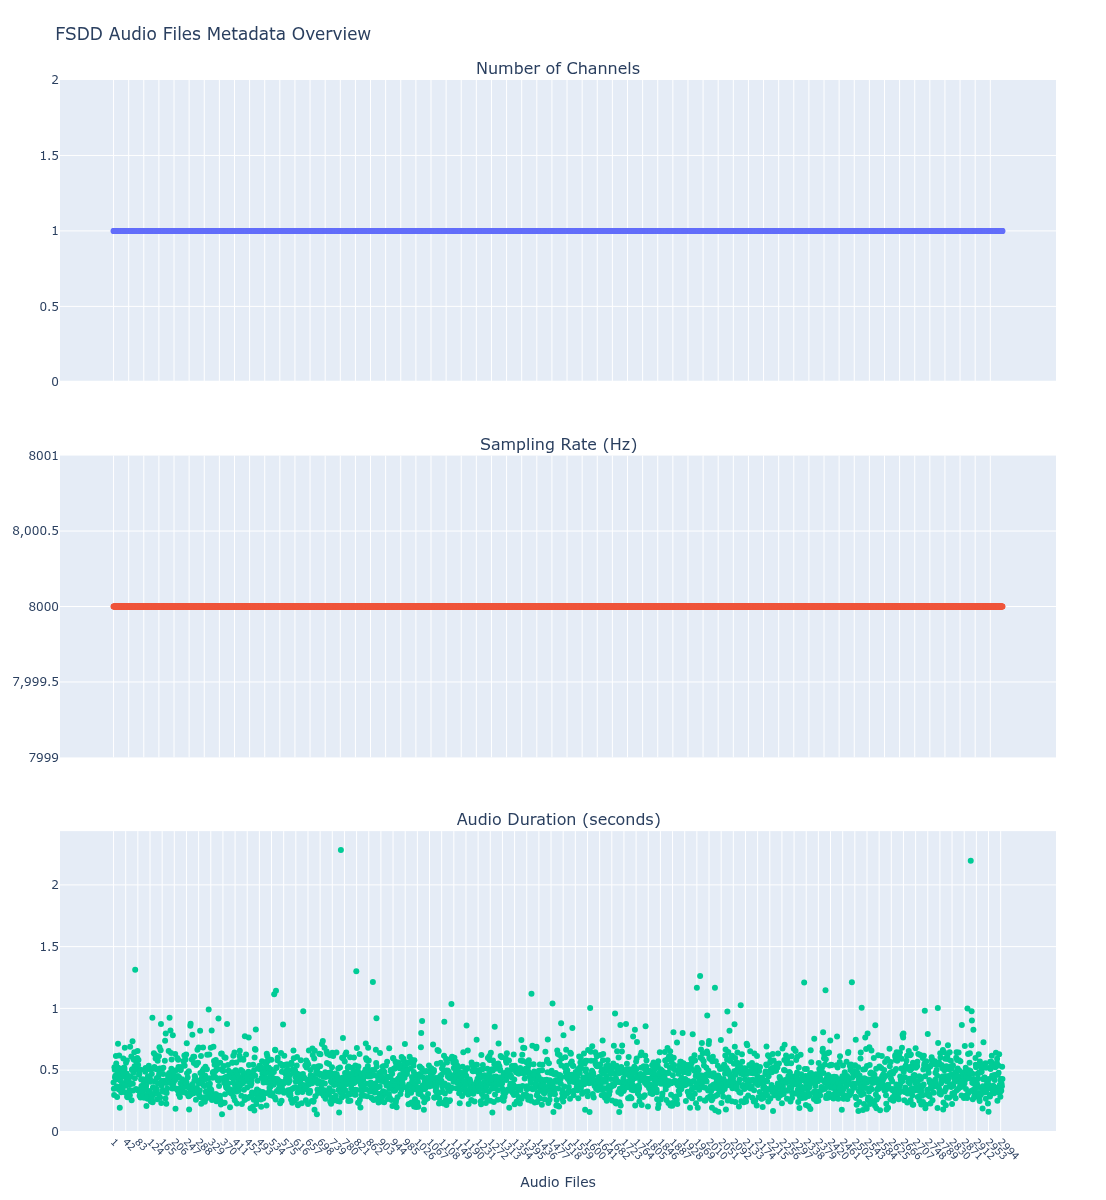

In [47]:
fig.add_trace(
    go.Scatter(x=x_labels_display, y=channels_list, mode='markers', marker=dict(size=6), name="Channels"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=x_labels_display, y=sampling_rate_list, mode='markers', marker=dict(size=6), name="Sampling Rate"),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=x_labels_display, y=duration_list, mode='markers', marker=dict(size=6), name="Duration"),
    row=3, col=1
)

fig.update_xaxes(tickangle=45, tickfont_size=10)
# fig.update_layout(autosize=True)

# Layout for full screen
fig.update_layout(
    title_text="FSDD Audio Files Metadata Overview",
    showlegend=False,
    height=1200,  # Large height for full screen
    width=1200,   # Wide enough for large screens
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.update_xaxes(title_text="Audio Files", row=3, col=1)
# fig.update_yaxes(title_text="Count", row=1, col=1)
# fig.update_yaxes(title_text="Hz", row=2, col=1)
# fig.update_yaxes(title_text="Seconds", row=3, col=1)

It is evident from the plot that **all the audio samples** have a **channel count of 1** and a **sample rate of 8000 Hz**. However, the duration of the recordings varies across the dataset. To better understand the distribution of durations, I plotted them as a histogram. This helps indicate the target size to which we should normalize the length of these audio recordings for consistent processing.

In [ ]:
for recording in recordings_list[:]:

    filename = os.path.basename(recording)
    label = int(filename.split('_')[0])  
    encoded_labels.append(label)

    ## Waveform represents air pressure variations over time
    waveform, samplerate = torchaudio.load(recording)

    # Apply noise reduction preprocessing
    if denoise_data:
        waveform = apply_bandpass_filter(waveform, samplerate)

    waveform = waveform / waveform.abs().max()

    # print(waveform.min(), waveform.max())

    # print(waveform.shape[1], len(waveform[0]))

    channels_list.append(waveform.shape[0])
    sampling_rate_list.append(samplerate)
    duration_list.append(waveform.shape[1] / samplerate)

    mfcc_transform = T.MFCC(
        sample_rate=samplerate,         # or 8000, depending on your waveform
        n_mfcc=13,                 # typically 13–40 coefficients
        melkwargs={
            "n_fft": 400,
            "hop_length": 160,
            "n_mels": 40
        }
    )

    mfcc_features = mfcc_transform(waveform)
    _, _, t_steps = mfcc_features.shape

    # print(mfcc_features.shape)

    updated_mfcc_features = pad_or_trim_mfcc(mfcc_features)

    # print(updated_mfcc_features)
    _, _, updated_t_steps = updated_mfcc_features.shape
    
    
    if updated_t_steps == 36:
        time_steps_list.append(updated_t_steps)
    else:
        print(updated_mfcc_features.shape)